# model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

import MLFunctions as mf # 사용자 정의 함수 패키지

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, f1_score

from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay

from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials

**get preprocessed data**

In [2]:
df_original = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
df = mf.get_preprocessed_model(df_original) # 전처리 된 데이터 반환 사용자 정의 함수
print(df.shape)
df.head()

(5109, 18)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.60000,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.89456,1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.50000,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.40000,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.00000,1,0,0,0,1,0,0,0,1,0


1. random forest
2. logistic regression

## model evaluation

In [3]:
y_target = df["stroke"]
X_features = df.drop(["stroke"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=156)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_pred_proba = rf_clf.predict_proba(X_test)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)

In [4]:
print(type(rf_clf).__name__)
mf.model_evaluation(y_test, rf_pred, rf_pred_proba)
print(type(lr_clf).__name__)
mf.model_evaluation(y_test, lr_pred, lr_pred_proba)

RandomForestClassifier
accuracy: 0.955, precision: 0.200, recall: 0.015, roc_auc: 0.820, f1: 0.028

LogisticRegression
accuracy: 0.957, precision: 0.000, recall: 0.000, roc_auc: 0.892, f1: 0.000



In [5]:
cm = confusion_matrix(y_test, rf_pred)
print(type(rf_clf).__name__)
print(cm)
print()
cm = confusion_matrix(y_test, lr_pred)
print(type(lr_clf).__name__)
print(cm)

RandomForestClassifier
[[1463    4]
 [  65    1]]

LogisticRegression
[[1467    0]
 [  66    0]]


# SMOTE

**오버 샘플링을 통한 불균형 데이터 처리**

In [6]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_features, y_target)
print(y_target.value_counts())
print(y_smote.value_counts())

0    4860
1     249
Name: stroke, dtype: int64
1    4860
0    4860
Name: stroke, dtype: int64


**파라미터 튜닝 없이 성능 측정**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=156)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_pred_proba = rf_clf.predict_proba(X_test)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
xgb_pred_proba = xgb_clf.predict_proba(X_test)

lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3398, number of negative: 3406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 6804, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002352
[LightGBM] [Info] Start training from score -0.002352


In [8]:
print(type(rf_clf).__name__)
mf.model_evaluation(y_test, rf_pred, rf_pred_proba)

print(type(lr_clf).__name__)
mf.model_evaluation(y_test, lr_pred, lr_pred_proba)

print(type(xgb_clf).__name__)
mf.model_evaluation(y_test, xgb_pred, xgb_pred_proba)

print(type(lgbm_clf).__name__)
mf.model_evaluation(y_test, lgbm_pred, lgbm_pred_proba)

RandomForestClassifier
accuracy: 0.963, precision: 0.972, recall: 0.953, roc_auc: 0.994, f1: 0.963

LogisticRegression
accuracy: 0.910, precision: 0.936, recall: 0.880, roc_auc: 0.975, f1: 0.907

XGBClassifier
accuracy: 0.959, precision: 0.963, recall: 0.954, roc_auc: 0.992, f1: 0.958

LGBMClassifier
accuracy: 0.962, precision: 0.968, recall: 0.956, roc_auc: 0.992, f1: 0.962



In [9]:
result = {"model":["RandomForest","LogisticRegression","XGBoost","LightGBM"],
         "accuracy":[0.963,0.912,0.958,0.960],
         "precision":[0.973,0.931,0.963,0.967],
         "recall":[0.951,0.890,0.953,0.951]}

result_df = pd.DataFrame.from_dict(result)
result_df.set_index("model", inplace=True)

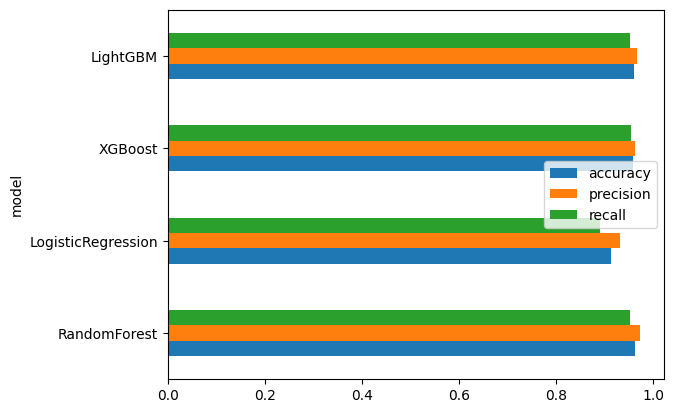

In [10]:
result_df.plot.barh()
plt.show()

		 -------- Random Forest --------


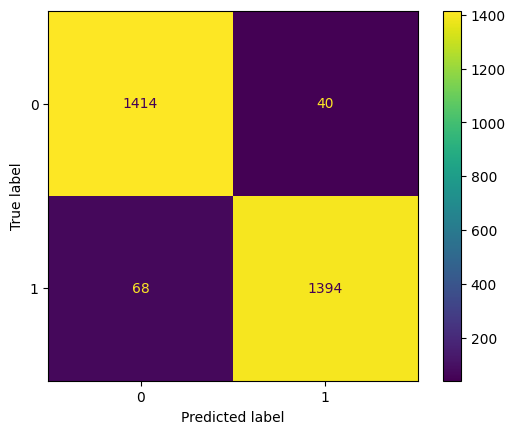

		-------- Logistic Regression --------


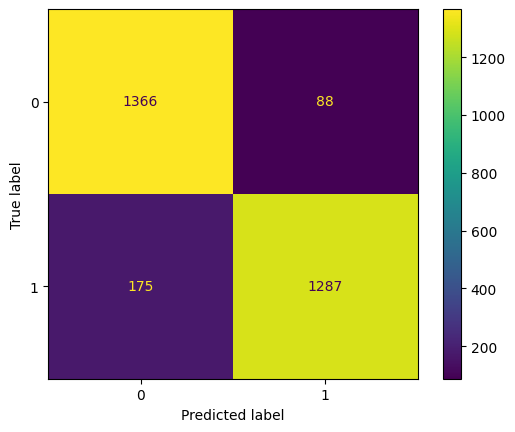

		   -------- XGBoost --------


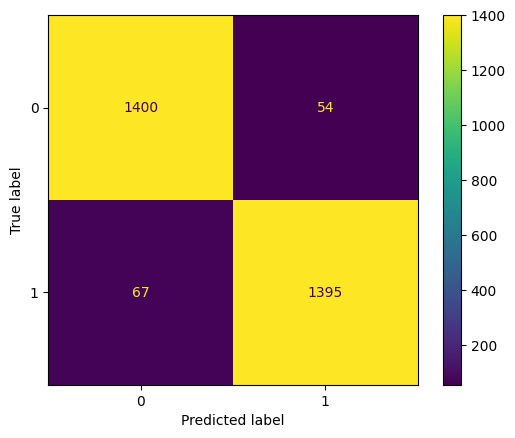

		  -------- LightGBM --------


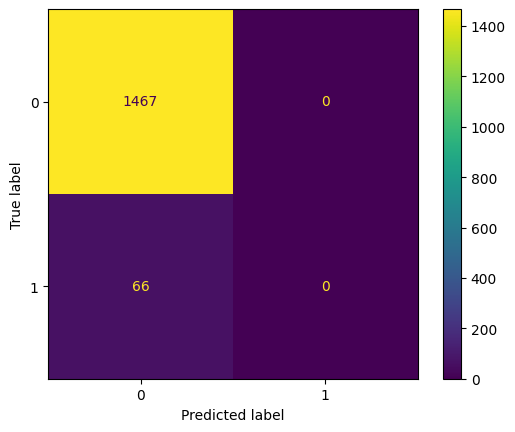

In [11]:
rf_cm = confusion_matrix(y_test, rf_pred)
print("\t\t -------- Random Forest --------")
matrix = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
matrix.plot()
plt.show()

lr_cm = confusion_matrix(y_test, lr_pred)
print("\t\t-------- Logistic Regression --------")
matrix = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
matrix.plot()
plt.show()

xgb_cm = confusion_matrix(y_test, xgb_pred)
print("\t\t   -------- XGBoost --------")
matrix = ConfusionMatrixDisplay(confusion_matrix=xgb_cm)
matrix.plot()
plt.show()

lgbm_cm = confusion_matrix(y_test, lgbm_pred)
print("\t\t  -------- LightGBM --------")
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

**본 프로젝트에서 가장 중요한 기준인 recall과 혼동행렬의 결과를 통해 xgboost 모델 채택**

# 파라미터 튜닝

In [13]:
#학습 데이터 / 테스트 데이터
X_train, X_test, y_train, y_test=train_test_split(X_smote, y_smote, test_size=0.3, random_state=156 )
# 학습 데이터 / 검증 데이터
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
               }

In [14]:
def xgb_tunning(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'], 
                            eval_metric='logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
        
    
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [17]:
trial_val = Trials()

best = fmin(fn= xgb_tunning,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [02:23<00:00,  2.87s/trial, best loss: -0.9650205761316872]
best: {'colsample_bytree': 0.6819691032385918, 'learning_rate': 0.09973526932696895, 'max_depth': 18.0, 'min_child_weight': 1.0}


In [18]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
                        round(best['colsample_bytree'], 3), round(best['learning_rate'], 3),
                        int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.682, learning_rate:0.1, max_depth:18, min_child_weight:1


In [20]:
xgb_clf = XGBClassifier(n_estimators=300, learning_rate=round(best['learning_rate'], 3), 
                            max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 3)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', 
                eval_set=evals, verbose=True)

pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)


mf.model_evaluation(y_test, pred, pred_proba)

[0]	validation_0-logloss:0.61452	validation_1-logloss:0.61960
[1]	validation_0-logloss:0.57393	validation_1-logloss:0.58827
[2]	validation_0-logloss:0.52795	validation_1-logloss:0.54801
[3]	validation_0-logloss:0.48425	validation_1-logloss:0.51039
[4]	validation_0-logloss:0.44038	validation_1-logloss:0.46959
[5]	validation_0-logloss:0.39894	validation_1-logloss:0.43155
[6]	validation_0-logloss:0.36445	validation_1-logloss:0.39901
[7]	validation_0-logloss:0.33278	validation_1-logloss:0.36950
[8]	validation_0-logloss:0.31224	validation_1-logloss:0.35133
[9]	validation_0-logloss:0.29044	validation_1-logloss:0.33202
[10]	validation_0-logloss:0.27335	validation_1-logloss:0.31774
[11]	validation_0-logloss:0.25165	validation_1-logloss:0.29750
[12]	validation_0-logloss:0.23878	validation_1-logloss:0.28632
[13]	validation_0-logloss:0.22126	validation_1-logloss:0.26910
[14]	validation_0-logloss:0.20619	validation_1-logloss:0.25572
[15]	validation_0-logloss:0.19258	validation_1-logloss:0.24356
[1

[130]	validation_0-logloss:0.01426	validation_1-logloss:0.08770
[131]	validation_0-logloss:0.01417	validation_1-logloss:0.08773
[132]	validation_0-logloss:0.01405	validation_1-logloss:0.08771
[133]	validation_0-logloss:0.01392	validation_1-logloss:0.08765
[134]	validation_0-logloss:0.01384	validation_1-logloss:0.08766
[135]	validation_0-logloss:0.01372	validation_1-logloss:0.08779
[136]	validation_0-logloss:0.01360	validation_1-logloss:0.08773
[137]	validation_0-logloss:0.01347	validation_1-logloss:0.08781
[138]	validation_0-logloss:0.01334	validation_1-logloss:0.08786
[139]	validation_0-logloss:0.01321	validation_1-logloss:0.08782
[140]	validation_0-logloss:0.01308	validation_1-logloss:0.08798
[141]	validation_0-logloss:0.01298	validation_1-logloss:0.08794
[142]	validation_0-logloss:0.01290	validation_1-logloss:0.08780
[143]	validation_0-logloss:0.01281	validation_1-logloss:0.08792
[144]	validation_0-logloss:0.01272	validation_1-logloss:0.08779
[145]	validation_0-logloss:0.01261	valid

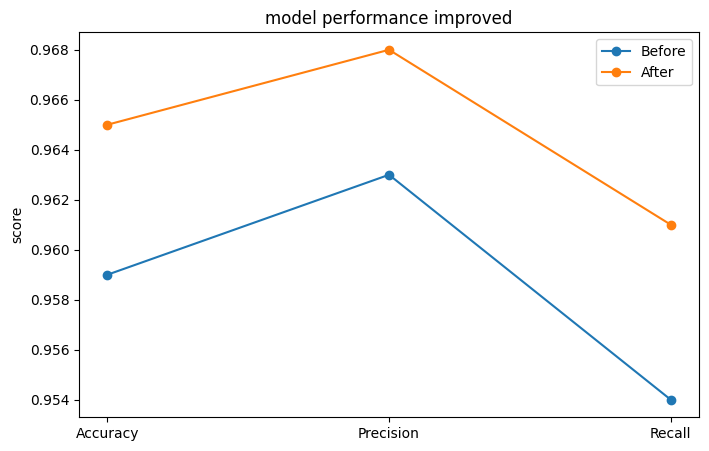

In [23]:
labels = ['Accuracy', 'Precision', 'Recall']
before_tuning = [0.959, 0.963, 0.954]
after_tuning = [0.965, 0.968, 0.961]

x = range(len(labels))


plt.figure(figsize=(8, 5))
plt.plot(labels, before_tuning, marker="o", label="Before")
plt.plot(labels, after_tuning, marker="o", label="After")

plt.ylabel('score')
plt.title('model performance improved')
plt.legend()


plt.show()